In [1]:
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array,load_img 
from keras.models import Sequential 
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense 
from keras import applications 
from keras.utils.np_utils import to_categorical 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math 
import datetime
import time
from sklearn import metrics
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [2]:
img_width, img_height = 224, 224 
 
top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = r'C:\Users\adith\Documents\Facial_Acne_Classification\dataset\train'
validation_data_dir = r'C:\Users\adith\Documents\Facial_Acne_Classification\dataset\val'
test_data_dir = r'C:\Users\adith\Documents\Facial_Acne_Classification\dataset\test'

batch_size = 32 

In [3]:
#Loading vgc16 model
vgg16 = applications.VGG16(include_top=False, weights='imagenet')
datagen = ImageDataGenerator(rescale=1. / 255) 
#needed to create the bottleneck .npy files

In [4]:
#__this can take an hour and half to run so only run it once. 
#once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__
start = datetime.datetime.now()
 
generator = datagen.flow_from_directory( 
    train_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode=None, 
    shuffle=False) 
 
nb_train_samples = len(generator.filenames) 
num_classes = len(generator.class_indices) 
 
predict_size_train = int(math.ceil(nb_train_samples / batch_size)) 
 
bottleneck_features_train = vgg16.predict(generator, predict_size_train) 
 
np.save('bottleneck_features_train.npy', bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 341 images belonging to 4 classes.
11/11 [==============================] - 84s 8s/step
Time:  0:01:24.426536


In [5]:
#__this can take an hour and half to run so only run it once. 
#once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__
start = datetime.datetime.now()
 
generator = datagen.flow_from_directory( 
    validation_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode=None, 
    shuffle=False) 
 
nb_train_samples = len(generator.filenames) 
num_classes = len(generator.class_indices) 
 
predict_size_train = int(math.ceil(nb_train_samples / batch_size)) 
 
bottleneck_features_validation = vgg16.predict(generator, predict_size_train) 
 
np.save('bottleneck_features_validation.npy', bottleneck_features_validation)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 112 images belonging to 4 classes.
4/4 [==============================] - 28s 7s/step
Time:  0:00:27.778798


In [6]:
#__this can take an hour and half to run so only run it once. 
#once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__
start = datetime.datetime.now()
 
generator = datagen.flow_from_directory( 
    test_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode=None, 
    shuffle=False) 
 
nb_train_samples = len(generator.filenames) 
num_classes = len(generator.class_indices) 
 
predict_size_train = int(math.ceil(nb_train_samples / batch_size)) 
 
bottleneck_features_validation = vgg16.predict(generator, predict_size_train) 
 
np.save('bottleneck_features_test.npy', bottleneck_features_validation)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 120 images belonging to 4 classes.
4/4 [==============================] - 29s 7s/step
Time:  0:00:29.665093


In [7]:
#training data
generator_top = datagen.flow_from_directory( 
   train_data_dir, 
   target_size=(img_width, img_height), 
   batch_size=batch_size, 
   class_mode='categorical', 
   shuffle=False) 
 
nb_train_samples = len(generator_top.filenames) 
num_classes = len(generator_top.class_indices) 
 
# load the bottleneck features saved earlier 
train_data = np.load('bottleneck_features_train.npy') 
 
# get the class labels for the training data, in the original order 
train_labels = generator_top.classes 
 
# convert the training labels to categorical vectors 
train_labels = to_categorical(train_labels, num_classes=num_classes)

Found 341 images belonging to 4 classes.


In [8]:
#validation data
generator_top = datagen.flow_from_directory( 
   validation_data_dir, 
   target_size=(img_width, img_height), 
   batch_size=batch_size, 
   class_mode='categorical', 
   shuffle=False) 
 
nb_train_samples = len(generator_top.filenames) 
num_classes = len(generator_top.class_indices) 
 
# load the bottleneck features saved earlier 
validation_data = np.load('bottleneck_features_validation.npy') 
 
# get the class labels for the training data, in the original order 
validation_labels = generator_top.classes 
 
# convert the training labels to categorical vectors 
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

Found 112 images belonging to 4 classes.


In [9]:
#test data
generator_top = datagen.flow_from_directory( 
   test_data_dir, 
   target_size=(img_width, img_height), 
   batch_size=batch_size, 
   class_mode='categorical', 
   shuffle=False) 
 
nb_train_samples = len(generator_top.filenames) 
num_classes = len(generator_top.class_indices) 
 
# load the bottleneck features saved earlier 
test_data = np.load('bottleneck_features_test.npy') 
 
# get the class labels for the training data, in the original order 
test_labels = generator_top.classes 
 
# convert the training labels to categorical vectors 
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 120 images belonging to 4 classes.


In [10]:
start = datetime.datetime.now()
model = Sequential() 
model.add(Flatten(input_shape=train_data.shape[1:])) 
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3))) 
model.add(Dropout(0.5)) 
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3))) 
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=optimizers.RMSprop(learning_rate=1e-4),metrics=['acc'])

In [11]:
# history = model.fit(np.array(train_data), np.array(train_labels), epochs=7,batch_size=batch_size, validation_data=(np.array(validation_data), np.array(validation_labels)))
history = model.fit(train_data, train_labels, epochs=100,batch_size=batch_size, validation_data=(validation_data, validation_labels))
model.save_weights(top_model_weights_path)

Epoch 1/100
11/11 [==============================] - 3s 125ms/step - loss: 1.4599 - acc: 0.2962 - val_loss: 1.2523 - val_acc: 0.2589
Epoch 2/100
11/11 [==============================] - 0s 32ms/step - loss: 1.1798 - acc: 0.4604 - val_loss: 1.0763 - val_acc: 0.4911
Epoch 3/100
11/11 [==============================] - 0s 32ms/step - loss: 1.1182 - acc: 0.4809 - val_loss: 0.9833 - val_acc: 0.6071
Epoch 4/100
11/11 [==============================] - 0s 33ms/step - loss: 0.9742 - acc: 0.5630 - val_loss: 1.0679 - val_acc: 0.5179
Epoch 5/100
11/11 [==============================] - 0s 31ms/step - loss: 0.9066 - acc: 0.6188 - val_loss: 0.9386 - val_acc: 0.6071
Epoch 6/100
11/11 [==============================] - 0s 32ms/step - loss: 0.8501 - acc: 0.6540 - val_loss: 0.9259 - val_acc: 0.5893
Epoch 7/100
11/11 [==============================] - 0s 32ms/step - loss: 0.8346 - acc: 0.6481 - val_loss: 0.8058 - val_acc: 0.6607
Epoch 8/100
11/11 [==============================] - 0s 33ms/step - loss: 0

In [12]:
(eval_loss, eval_accuracy) = model.evaluate(validation_data, validation_labels, batch_size=batch_size,verbose=1)
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("[INFO] Loss: {}".format(eval_loss)) 
end= datetime.datetime.now()
elapsed= end-start 
print ('Time: ', elapsed)

4/4 [==============================] - 0s 9ms/step - loss: 0.8369 - acc: 0.7232
[INFO] accuracy: 72.32%
[INFO] Loss: 0.8369274139404297
Time:  0:00:38.846385


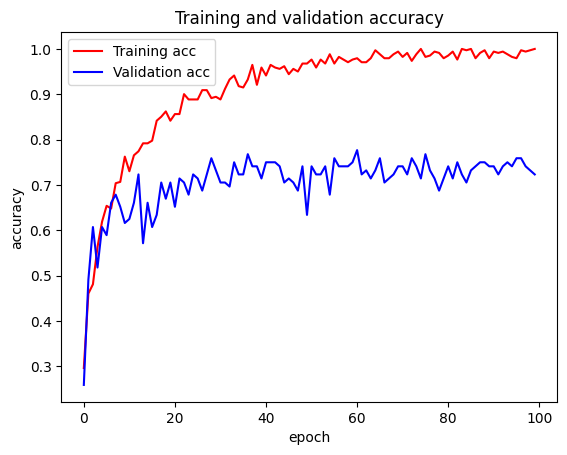

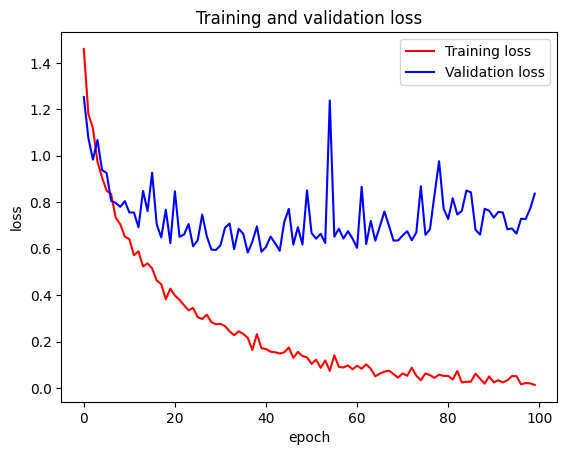

In [13]:
#Graphing our training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()

In [14]:
model.evaluate(test_data,test_labels)

4/4 [==============================] - 0s 9ms/step - loss: 0.9724 - acc: 0.8000


[0.9723860025405884, 0.800000011920929]

In [15]:
preds= np.round(model.predict(test_data), 0)
test_labels

4/4 [==============================] - 0s 6ms/step


array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],


In [16]:
labels = ['stage1','stage2','stage3','stage4']
classification_matrics=metrics.classification_report(test_labels,preds,target_names=labels)
print(classification_matrics)

              precision    recall  f1-score   support

      stage1       0.74      0.82      0.78        28
      stage2       0.80      0.50      0.62        32
      stage3       0.76      0.87      0.81        30
      stage4       0.91      1.00      0.95        30

   micro avg       0.81      0.79      0.80       120
   macro avg       0.80      0.80      0.79       120
weighted avg       0.80      0.79      0.79       120
 samples avg       0.79      0.79      0.79       120



C:\Users\adith\anaconda3\envs\aiml\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
print("Accuracy:",accuracy_score(preds,test_labels))

Accuracy: 0.7916666666666666


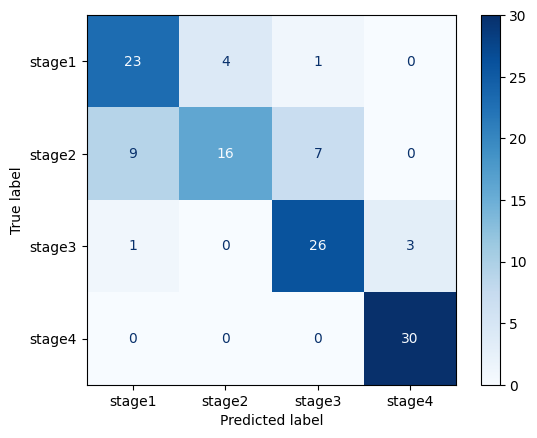

In [18]:
# test_data_classes=list(pd.DataFrame(test_labels).idxmax(axis=1))
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)
cm = confusion_matrix(categorical_test_labels.to_numpy(), categorical_preds.to_numpy())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [19]:
model = model.save('model/model.h5')

In [20]:
model = keras.models.load_model('model/model.h5')